## Problem 1
Generate spikes for 10 s (or longer if you want better statistics) using a Poisson spike generator with a constant rate of 100 Hz, and record their times of occurrence. Compute the coefficient of variation of the interspike intervals, and the Fano factor for spike counts obtained over counting intervals ranging from 1 to 100 ms. Plot the interspike interval histogram.

c_v =  0.99787
   T           Fano
   0.0010000   0.9738693
   0.0050000   0.9298712
   0.0100000   0.8929085
   0.0500000   0.9864950
   0.1000000   1.0655777


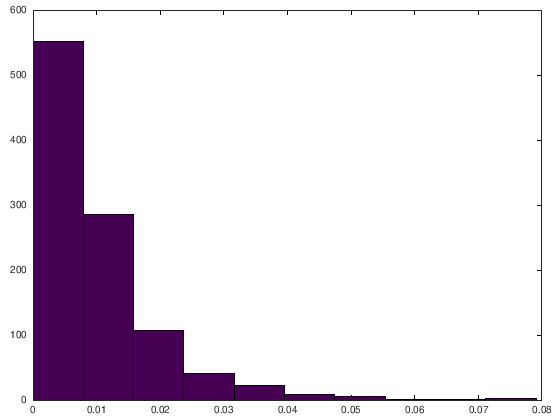

In [1]:
r = 100;
T = 10;

times = [0];
while times(end) < T
    next_time = times(end) - log(rand(1))/r;
    times = [times next_time];
end
intervals = times(2:end) - times(1:end-1);
times = times(2:end-1);

c_v = std(intervals) / mean(intervals)
hist(intervals)

fano_intervals = [0.001 0.005 0.01 0.05 0.1];
fano = [];
for dt = fano_intervals
    bins = 0:dt:T;
    counts = (floor(times / dt) * dt)';
    counts = sum((counts >= bins(1:end-1)) & (counts < bins(2:end)), 1);
    fano = [fano var(counts) / mean(counts)];
end

disp('   T           Fano')
disp([fano_intervals' fano'])

## Problem 2
Add a refractory period to the Poisson spike generator by allowing the firing rate to depend on time. Initially, set the firing rate to a constant value, $r(t) = r_0$. After every spike, set $r(t)$ to 0, and then allow it to recover exponentially back to $r_0$ with a time constant $\tau_{\text{ref}}$ that controls the refractory recovery rate. In other words, have $r(t)$ obey the equation

$$\tau_{\text{ref}} \frac{dr}{dt} = r_0 - r$$

except immediately after a spike, when it is set to 0. Plot the coefficient of variation as a function of $\tau_{\text{ref}}$ over the range 1 ms $\le \tau_{\text{ref}} \le$ 20 ms, and plot interspike interval histograms for a few different values of $\tau_{\text{ref}}$ in this range. Compute the Fano factor for spike counts obtained over counting intervals ranging from 1 to 100 ms for the case $\tau_{\text{ref}}$ = 10 ms.

   T           Fano
   0.0010000   0.9422942
   0.0050000   0.9813869
   0.0100000   0.9558278
   0.0500000   0.8964894
   0.1000000   0.9212541


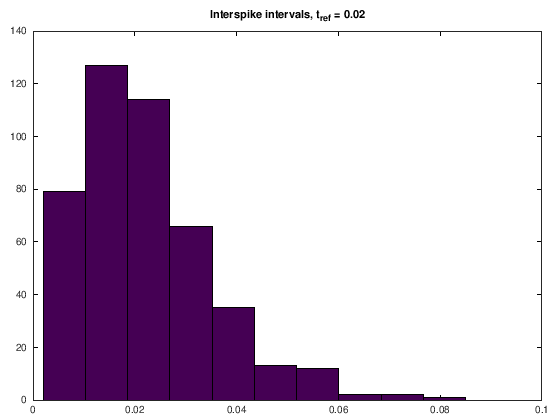

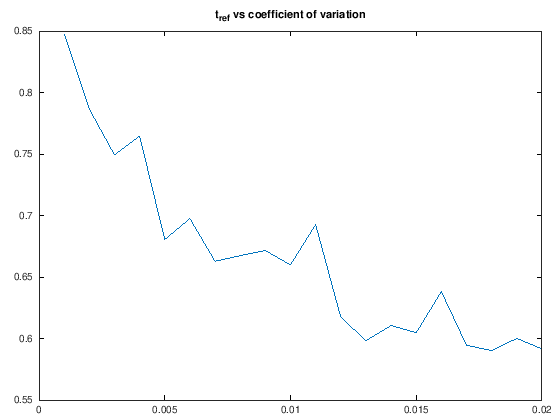

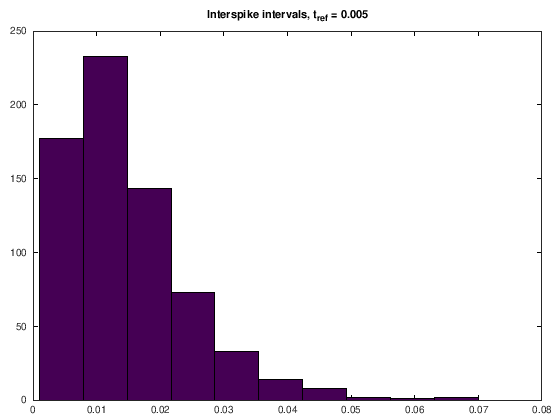

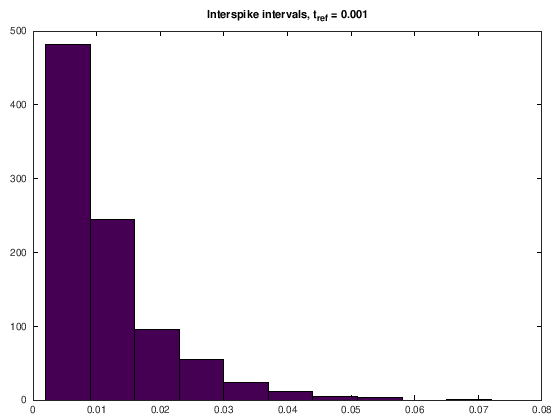

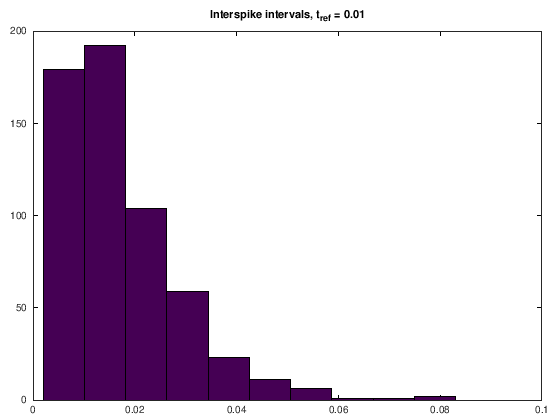

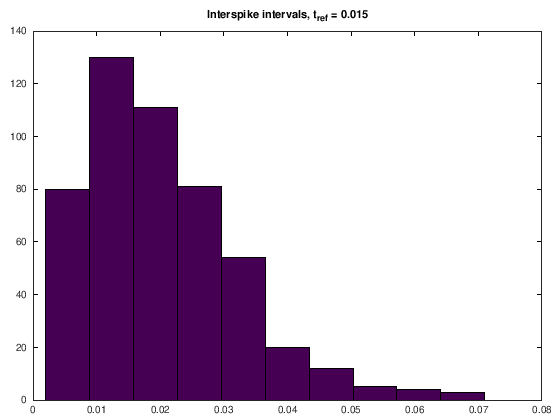

In [2]:
r0 = 100;
r = r0;
T = 10;
dt = 0.001;
times = dt:dt:T;

c_v = [];
taus = dt * floor((dt:dt:0.02) / dt);
for tau = taus
    spikes = [];
    for t = times
        is_spike = r * dt > rand(1);
        spikes = [spikes is_spike];
        if is_spike
            r = 0;
        elseif r < r0
            dr = (r0 - r) * dt / tau;
            r = r + dr;
        end
    end
    
    spike_times = find(spikes) * dt;
    intervals = spike_times(1:end) - [0 spike_times(1:end - 1)];
    c_v = [c_v std(intervals) / mean(intervals)];
    
    if tau == 0.001 || mod(tau, 0.005) == 0
        figure()
        hist(intervals);
        title(["Interspike intervals, t_{ref} = ", num2str(tau)])
    end
    
    if tau != 0.01
        continue
    end
    
    fano_intervals = [0.001 0.005 0.01 0.05 0.1];
    fano = [];
    for T_f = fano_intervals
        counts = sum(reshape(spikes, [], T_f / dt), 2);
        fano = [fano var(counts) / mean(counts)];
    end

    disp('   T           Fano')
    disp([fano_intervals' fano'])
end

figure()
plot(taus, c_v);
title("t_{ref} vs coefficient of variation")

## Problem 3
Compute autocorrelation histograms of spike trains generated by a Poisson generator with a constant firing rate of 100 Hz, a constant firing rate of 100 Hz together with a refractory period modeled as in exercise 2 with $\tau_{\text{ref}}$ = 10 ms, and a variable firing rate $r(t) = 100(1 + \cos(2 \pi t / 25 \text{ms}))$ Hz. Plot the histograms over a range from 0 to 100 ms.

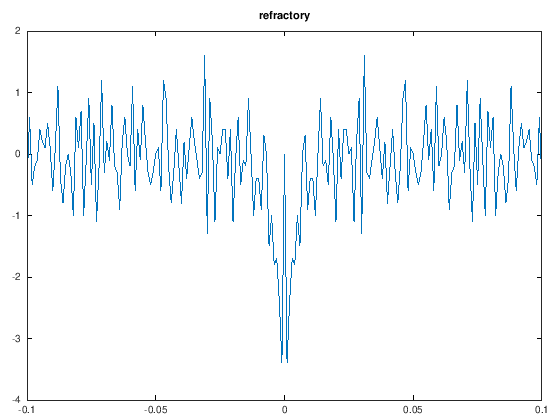

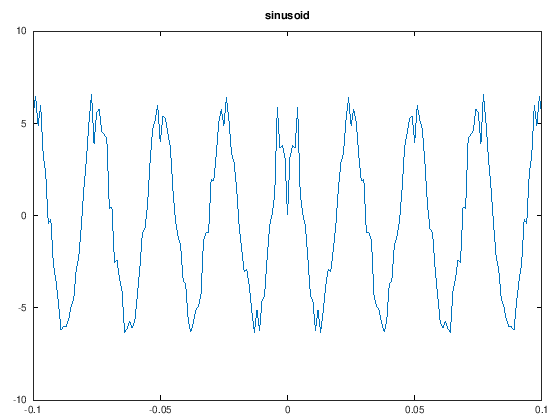

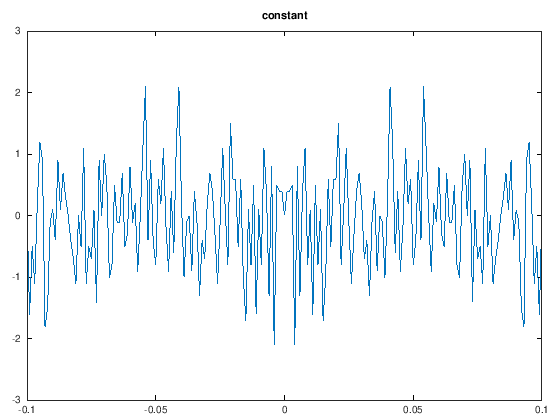

In [3]:
function retval = get_spike_train(T, dt, r0, tau, sinusoid)
    r = r0;
    retval = [];
    for t = dt:dt:T
        if isa(sinusoid, "function_handle")
            r = sinusoid(t);
        end

        is_spike = r * dt > rand(1);
        retval = [retval is_spike];
        
        if tau <= 0
            continue
        elseif is_spike
            r = 0;
        elseif r < r0
            dr = (r0 - r) * dt / tau;
            r = r + dr;
        end
    end
endfunction

function plot_autocorr(spikes, dt, T, bin_size, max_bin, name)
    times = find(spikes) * dt;
    bins = round(-max_bin/bin_size:1:max_bin/bin_size);
    n = max(size(times));
    
    intervals = round((times' - times) / bin_size);
    intervals = intervals(find(abs(intervals) <= bins(end)));

    N = sum(intervals == bins, 1);
    autocorr = N/T - n^2 * bin_size / T^2;
    
    autocorr((max_bin / bin_size) + 1) = 0;
    figure()
    plot(bins * bin_size, autocorr);
    title(name);
endfunction

T = 10;
dt = 0.001;
r0 = 100;

spikes_const = get_spike_train(T, dt, r0, 0, 0);
spikes_refract = get_spike_train(T, dt, r0, 0.01, 0);
spikes_sin = get_spike_train(T, dt, 0, 0, @(t) 100 * (1 + cos(2 * pi * t / 0.025)));

bin_size = 0.001;
max_bin = 0.1;
plot_autocorr(spikes_const, dt, T, bin_size, max_bin, "constant");
plot_autocorr(spikes_refract, dt, T, bin_size, max_bin, "refractory");
plot_autocorr(spikes_sin, dt, T, bin_size, max_bin, "sinusoid");

## Problem 4
Generate a Poisson spike train with a time-dependent firing rate $r(t) = 100(1 + \cos(2 \pi t/300 \text{ ms}))$ Hz. Approximate the firing rate from
this spike train using a variable $r_{\text{approx}}$ that satisfies

$$\tau_{\text{approx}} \frac{dr_{\text{approx}}}{dt} = -r_{\text{approx}}$$

except that $r_{\text{approx}} \rightarrow r_{\text{approx}} + 1/\tau_{\text{approx}}$ every time a spike occurs. Make plots of the true rate, the spike sequence generated, and the estimated rate. Experiment with a few different values of $\tau_{\text{approx}}$ in the range of 1 to 100 ms. Determine the best value of $\tau_{\text{approx}}$ by computing the average squared error of the estimate, $\int dt(r(t) - r_{\text{approx}}(t))^2$, for different values of $\tau_{\text{approx}}$, and finding the value of $\tau_{\text{approx}}$ that minimizes this error.

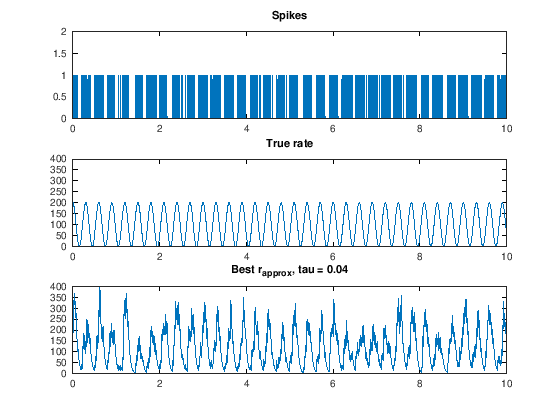

In [4]:
r_t = @(t) 100 * (1 + cos(2 * pi * t / 0.3));
dt = 0.001;
T = 10;

times = dt:dt:T;
rate = r_t(times);
spikes = rate * dt > rand(size(times));

subplot(3, 1, 1)
plot(times, spikes);
axis([-inf inf 0 2]);
title("Spikes");

subplot(3, 1, 2)
plot(times, rate);
axis([0, T, 0, 400]);
title("True rate");

best_tau = 0;
best_error = inf;
best_approx = [];

for tau = 0.001:0.001:0.1
    r_approx = [];
    last_r = r_t(0);
    for is_spike = spikes
        if is_spike
            dr = 1 / tau;
        else
            dr = -last_r * dt / tau;
        end
        r_approx = [r_approx last_r + dr];
        last_r = r_approx(end);
    end
    
    err = sum((rate - r_approx).^2);
    if err < best_error
        best_tau = tau;
        best_error = err;
        best_approx = r_approx;
    end
end

subplot(3, 1, 3)
plot(times, best_approx);
title(["Best r_{approx}, tau = ", num2str(best_tau)]);

## Problem 5
For a constant rate Poisson process, every specific (up to a finite resolution) sequence of $N$ spikes occurring over a given time interval is equally likely. This seems paradoxical because we certainly do not expect to see all $N$ spikes appearing within the first 1% of the time interval. Resolve this paradox.

### Answer
There are many fewer ways to squeeze all N spikes into the first 1% of the time interval than there are ways to spread them out over a wider range. So while each individual placement is equally likely, there are many more placements that are spread out than that are squeezed together.

## Problem 6
Build an approximate white-noise stimulus by choosing random values at discrete times separated by a time-step interval $\Delta t$. Plot its autocorrelation function and power spectrum. Discuss how well this stimulus matches an ideal white-noise stimulus given the value of $\Delta t$ you used.

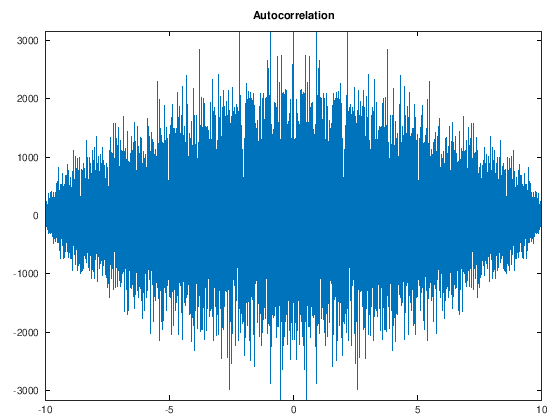

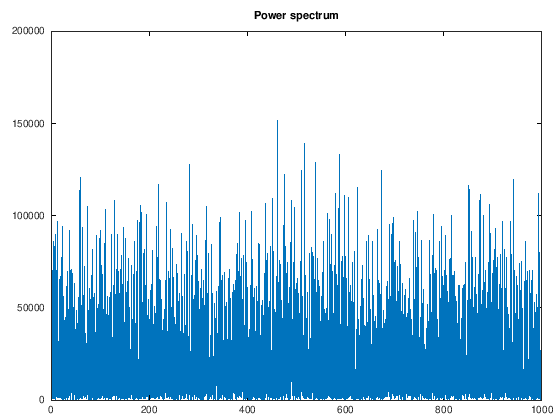

In [5]:
pkg load signal;

dt = 0.001;
T = 10;
sigma_noise = 10;

timesteps = T/dt;
scale = sigma_noise / sqrt(dt);
noise = randn([1, timesteps]) * scale;

autocorr = xcorr(noise, 'biased');

figure()
plot(-T+dt:dt:T-dt, autocorr);
axis([-T, T, -10 * scale, 10 * scale]);
title("Autocorrelation");

psd = 2 * abs(fft(autocorr)(timesteps - 1:end)) / T;
frequencies = (0:timesteps)/(timesteps * dt);
figure()
plot(frequencies, psd);
title("Power spectrum");

Frequencies above $1/\Delta t$ cannot be produced by this method.

## Problem 7
Consider a model with a firing rate determined in terms of a stimulus $s(t)$ by integrating the equation

$$\tau_r \frac{dr_{\text{est}}(t)}{dt} = [r_0 + s]_+ - r_{\text{est}}(t),$$

where $r_0$ is a constant that determines the background firing rate and $\tau_r = 20$ ms. Drive the model with an approximate white-noise stimulus. Adjust the amplitude of the white-noise and the parameter $r_0$ so that rectification is not a big effect (i.e. $r_{0} + s > 0$ most of the time). From the responses of the model, compute the stimulus-response correlation function, $Q_{rs}$. Next, generate spikes from this model using a Poisson generator with a rate $r_{\text{est}}(t)$, and compute the spike-triggered average stimulus $C$ from the spike trains produced by the white-noise stimulus. By comparing the stimulus-response correlation function with the spike-triggered average, verify that

$$C(\tau)=\frac{1}{\langle r \rangle}Q_{rs}(-\tau)$$

is satisfied. Examine what happens if you set $r_0 = 0$, so that the white-noise stimulus becomes half-wave rectified.

Rectified ratio: 6%


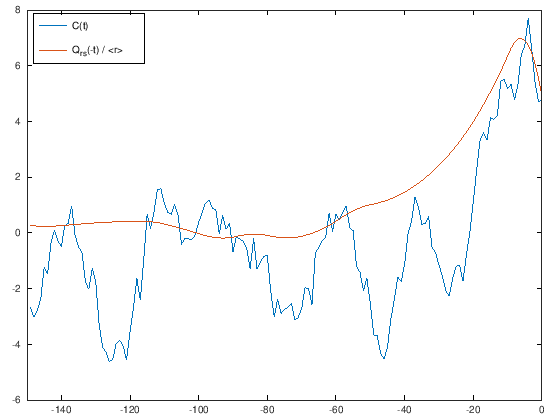

In [6]:
pkg load signal;

T = 10;
dt = 0.001;
timesteps = T/dt;

r0 = 50;
tau = 0.02;
var_stim = 10;
dt_stim = 0.01;

stim_steps = T / dt_stim;
stim = randn([1, stim_steps]) * sqrt(var_stim / dt_stim);
stim = repelems(stim, [1:stim_steps; dt_stim / dt * ones(1, stim_steps)]);

r = [r0];
rectified = 0;
for t = 1:timesteps
    combined = r0 + stim(t);
    if combined < 0
        rectified = rectified + 1;
        combined = 0;
    end
    
    dr = dt * (combined - r(end)) / tau;
    r = [r, r(end) + dr];
end
r = r(2:end);

disp(["Rectified ratio: ", num2str(100 * rectified / timesteps), "%"])

corr = xcov(r, stim, "biased");

r_max = max(r);
last_spike = 0;
spike_times = [];
while last_spike <= T
    last_spike = last_spike - log(rand(1)) / r_max;
    spike_times = [spike_times last_spike];
end
spike_times = floor(spike_times(1:end-1) / dt);
keep = (r(spike_times) / r_max) >= rand(size(spike_times));
spike_times = spike_times(keep);
r_avg = sum(keep) / T;

window_size = 150;
window = -window_size + 1:0;
trig_avg = mean(stim(spike_times(spike_times >= window_size)' + window), 1);

plot(window, trig_avg)
hold on
plot(window, corr(timesteps - window) / r_avg)
hold off
axis([-window_size 0])
legend('C(t)', 'Q_{rs}(-t) / <r>', 'Location', 'northwest')

## Problem 8
`c1p8.mat` contains data collected and provided by Rob de Ruyter van Steveninck from a fly H1 neuron responding to an approximate white-noise visual motion stimulus. Data were collected for 20 minutes at a sampling rate of 500 Hz. In the file, `rho` is a vector that gives the sequence of spiking events or nonevents at the sampled times (every 2 ms). When an element of `rho` is one, this indicates the presence of a spike at the corresponding time, whereas a zero value indicates no spike. The variable `stim` gives the sequence of stimulus values at the sampled times. Calculate and plot the spike-triggered average from these data over the range from 0 to 300 ms (150 time steps).

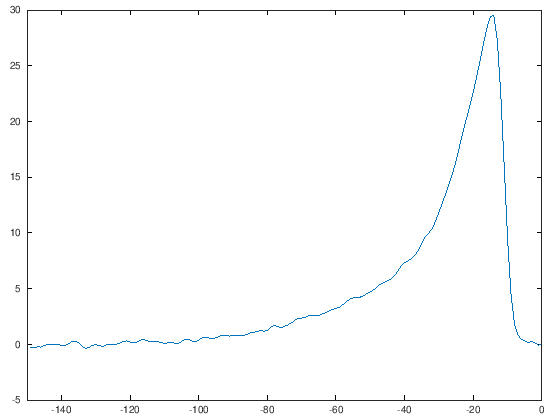

In [7]:
load('../data/c1p8.mat');

window_size = 150;
window = 1-window_size:1:0;
spikes = find(rho);
spikes = spikes(spikes >= window_size);
triggers = stim(spikes + window);
trig_avg = mean(triggers, 1);

plot(window, trig_avg)
axis([-window_size 0 -inf inf]);

## Problem 9
Using the data of problem 8, calculate and plot stimulus averages triggered on events consisting of a pair of spikes (which need not necessarily be adjacent) separated by a given interval (as in figure 1.10). Plot these two-spike-triggered average stimuli for various separation intervals ranging from 2 to 100 ms. (Hint: use convolution for pattern matching: e.g. `find(conv(rho,[1 0 1])==2)` will contain the indices of all the events with two spikes separated by 4 ms.) Plot, as a function of the separation between the two spikes, the magnitude of the difference between the two-spike-triggered average and the sum of two single-spike-triggered averages (obtained in exercise 8) separated by the same time interval. At what temporal separation does this difference become negligibly small.

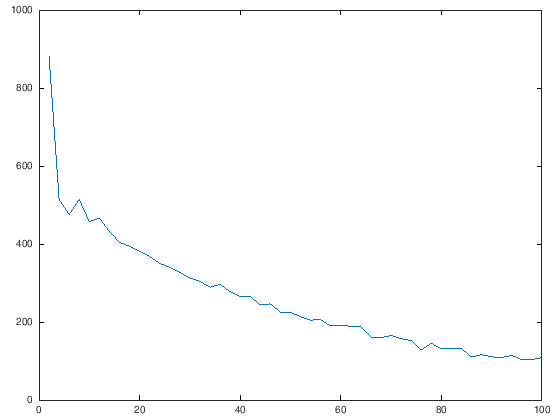

In [8]:
differences = [];
for separation = 1:50
    filter = [1 zeros([1 separation - 1]) 1];
    pair_spikes = find(conv(rho, filter) == 2);
    pair_spikes = pair_spikes(pair_spikes >= 150);
    
    pair_triggers = stim(pair_spikes + window);
    pair_trig_avg = mean(pair_triggers, 1);
    
    sum_trig_avg = [trig_avg];
    sum_trig_avg(1:end-separation) = sum_trig_avg(1:end-separation) + trig_avg(separation + 1:end);
    
    differences = [differences sum(abs(pair_trig_avg - sum_trig_avg))];
end

plot(2:2:100, differences)

It seems that the error flattens out after around 60-70ms.

## Problem 10
Using the data of problem 8, find the spike-triggered average stimulus for events that contain exactly two adjacent spikes separated by various different intervals ranging from 2 to 100 ms (e.g. for 4 ms, the event `[1 0 1]` but not the event `[1 1 1]`). This is distinct from exercise 9 in which we only required two spikes separated by a given interval, but did not restrict what happened between the two spikes. Compare results of the exclusive case considered here with those of the inclusive two-spike-triggered average computed in exercise 9. In what ways and why are they different?

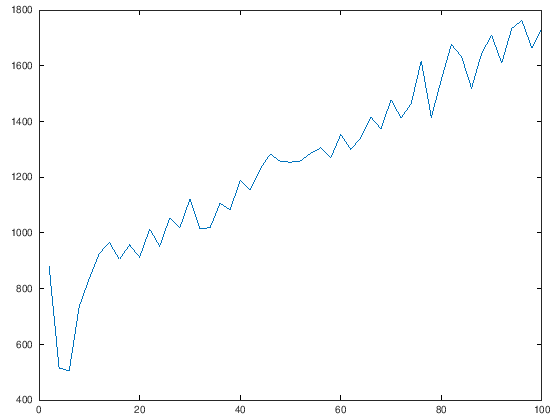

In [9]:
differences = [];
for separation = 1:50
    pair_filter = [1 zeros([1 separation - 1]) 1];
    exclusive_filter = 1 - pair_filter;
    pair_spikes = find((conv(rho, pair_filter) == 2) & (conv(rho, exclusive_filter) == 0));
    pair_spikes = pair_spikes(pair_spikes >= 150);
    
    pair_triggers = stim(pair_spikes + window);
    pair_trig_avg = mean(pair_triggers, 1);
    
    sum_trig_avg = [trig_avg];
    sum_trig_avg(1:end-separation) = sum_trig_avg(1:end-separation) + trig_avg(separation + 1:end);
    
    differences = [differences sum(abs(pair_trig_avg - sum_trig_avg))];
end

plot(2:2:100, differences)

For there to be a large interval between two spikes, we would need a strong inhibitory stimulus between the first spike and the second. This cannot be modeled as the simple sum of two excitatory stimuli, so the error grows as the interval size increases.